# Neutron transport in H slab

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [46]:
name='Alexander Hedene'

In this experiment we will put together our previous knowledge to track neutrons in a homogeneous medium filled with liquid hydrogen. We will track neutrons in 3-dimensions (although investigate the spatial dependence of the flux in 1 dimension only, and we will consider that the space is infinite in $y$ and $z$ directions, and finite in $x$). This is not a very realistic problem, and it is also not a practically relevant one, however it provides an excellent opportunity for us to see how the pieces of neutron transport can be put together. Since the physics is very simple in this case, our approximations are more or less valid:
- there is only two reaction on H-1: scattering and capture
- there are no resonances in the H-1 cross sections.
- scattering can be considered elastic and isotropic in CoM almost for every neutron energy
- we consider that H atoms are at rest (ie. temperature is 0K), so we do not need to consider any upscattering.
- we even neglect any molecular bounds between H atoms.

We are not going to write too much code here, because in fact we have already done most of the necessary preparation during the previous datalabs.

We will consider that the density of the liquid is 0.07085 g/cm3, and there is a 3 MeV neutron point source placed at $x=0.0,y=0.0,z=0.0$.

Our goal will be to plot the trajectories of neutrons and to estimate the flux vs the x coordinate (although, one could argue that for a point source we should measure the flux vs the radial distance from the source since the problem is spherical).

In [47]:
import numpy as np
import matplotlib.pyplot as plt

##  XS

### Microscopic  XS

First we obtain the microscopic cross sections for scattering and capture. We can see that the scattering is nearly constant at epithermal energies, and the capture reaction is also very smooth. We can also notice that most of the reactions are going to be scattering reactions.

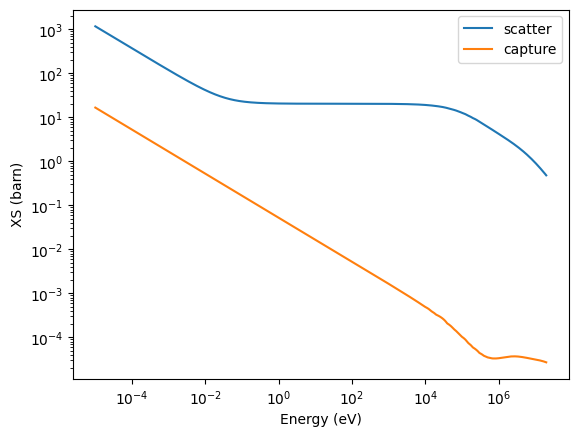

In [48]:
xsscatter=np.loadtxt('05b-xs_Hscatter.dat',skiprows=2)
Es=xsscatter[:,0]
XSs=xsscatter[:,1]

xscapture=np.loadtxt('05b-xs_Hcapture.dat',skiprows=2)
Ec=xscapture[:,0]
XSc=xscapture[:,1]

plt.figure()
plt.loglog(Es,XSs,label='scatter')
plt.loglog(Ec,XSc,label='capture')
plt.xlabel('Energy (eV)')
plt.ylabel('XS (barn)')
plt.legend()
plt.show()

### Macroscopic XS

Now, we will multiply with the atom density to obtain the macroscopic cross sections.

We will consider that our liquid is made of H atoms. Although, we know that it is not the case in reality.

In [49]:
density = 0.07085 #g/cm3
A = 1
Numdens = density * 6.022E23 / A #let's ignore that it is H2 molecule

MXSc= XSc * Numdens*1e-24
MXSs= XSs * Numdens*1e-24

## Path to next collision

In the previous datalab we saw that

$\exp(-\Sigma_t x)$ is the probability that a neutron moves a distance dx without any interaction.

and 

$\Sigma_t \exp(-\Sigma_t x)dx$ is the probability that the neutron has its interaction in dx.

So

$p(x)=\Sigma_t \exp(-\Sigma_t x)$

Thus

$F(x)=1-\exp(\Sigma_tx)$

If we take the inverse, to sample a random path

$x=-\frac{\ln(1-r)}{\Sigma_t}$

but if r is uniform over $[0,1)$, than $1-r$ is also uniform over $[0,1)$, so this simplifies to

$x=-\frac{\ln r}{\Sigma_t}$

**Note** speed is everything in MC calculations. Although here we don't tried to avoid every unecessary operation, but this example is just to highlight, that sometimes operations can be avoided with some reasoning.

So we can define the `distanceToCollision` function to sample a distance between two collision sites.

In [50]:
def distanceToCollision(SigT,N=1):
    x=np.random.uniform(0,1,N)
    return -np.log(x)/SigT

Let's play a bit with this one. Between 1-10000 eV the scattering cross section is still more or less constant, and several order of magnitude larger than the capture cross section, so for these energies we do not expect to have large differences between mean free path. For faster energies (eg. 1 MeV) we see a longer distance.

Energy: 1.0 eV, Total XS: 0.885462681376117 1/cm
Energy: 100.0 eV, Total XS: 0.8716969390531362 1/cm
Energy: 10000.0 eV, Total XS: 0.8185359199969066 1/cm
Energy: 1000000.0 eV, Total XS: 0.1811671217019197 1/cm


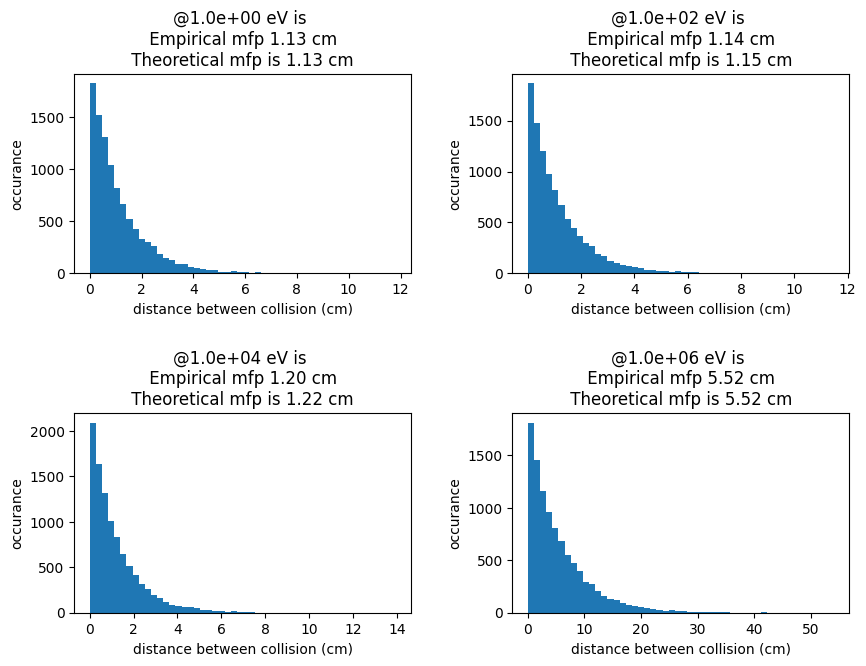

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
fig.subplots_adjust(hspace=.7)
fig.subplots_adjust(wspace=.3)
for i,E in enumerate([1e0,1e2,1e4,1e6]):
    SigS=np.interp(E,Es,MXSs) 
    SigC=np.interp(E,Ec,MXSc) 
    SigT=SigS+SigC
    print('Energy: {} eV, Total XS: {} 1/cm'.format(E,SigT))
    ds=distanceToCollision(SigT,10000)
    axs[int(i>=2), i%2].hist(ds,50)
    axs[int(i>=2), i%2].set_xlabel('distance between collision (cm)')
    axs[int(i>=2), i%2].set_ylabel('occurance')
    axs[int(i>=2), i%2].set_title(
        '@%.1e eV is \n Empirical mfp %.2f cm \n Theoretical mfp is %.2f cm '%(E,np.mean(ds),1/SigT))

## Reaction type

The probability of reaction $i$ happening at energy $E$ is 

\begin{equation}
\frac{\Sigma_i(E)}{\Sigma_t(E)}
\end{equation}

In our example only two reactions might happen: scattering or capture, So a simple condition can be used to decide which happens. Note that the function would not necessarily require $\Sigma_t$ as input. We also saw that `np.random.choice` could handle this for us.

In [52]:
def reactionType(SigS,SigC,SigT): #TODO: more generic for any number of reactions.
    x=np.random.uniform(0,1)
    if x < SigS/SigT:
        return 'scatter'
    else:
        return 'capture'

## Scattering and directions

During developing the theory of elastic scattering, we have assumed that scattering is isotropic in the Center-of-Mass frame, and we found a relation between the CM and LAB angles:

\begin{equation}
\tan \theta_L = \frac{\sin \theta_C}{\frac{1}{A}+\cos \theta_C}
\end{equation}

It was also derived how the outgoing neutron energy depends on the incoming energy and the scattering cosine:

\begin{equation}
E_f=\Big[\frac{(1+\alpha)+(1-\alpha)\cos \theta_C}{2}\Big]E_i
\end{equation}

Now we implement the `elasticScatter()` function which will sample the outgoing LAB energy for a neutron at a certain ingoing LAB energy.

In [53]:
def elasticScatter(E):
    muC=np.random.uniform(-1,1)
    thetaC=np.arccos(muC)
    E=(((1+alpha)+(1-alpha)*muC)/2)*E
    thetaL=np.arctan2(np.sin(thetaC),((1/A)+muC))
    muL=np.cos(thetaL)
    return E, muL

When the neutron is born we assume it is being emitted isotropically from the source, thus we need a function which samples random directions. For the random directions we have to keep in mind that it is not theta which is uniformly distributed, but the cosine of the angle, as we saw during the previous datalab.

For transforming the directions of a neutron after scattering we can use the following formulae (from https://docs.openmc.org/en/v0.10.0/methods/physics.html), which is just based on coordinate transformation.

\begin{equation}
u' = \mu u + \frac{\sqrt{1 - \mu^2} ( uw \cos\phi - v \sin\phi )}{\sqrt{1 -
w^2}} 
\end{equation}

\begin{equation}
v' = \mu v + \frac{\sqrt{1 - \mu^2} ( vw \cos\phi + u \sin\phi )}{\sqrt{1 -
w^2}} 
\end{equation}

\begin{equation}
w' = \mu w - \sqrt{1 - \mu^2} \sqrt{1 - w^2} \cos\phi
\end{equation}

In [54]:
def randomDir():
    mu=np.random.uniform(-1,1)
    theta=np.arccos(mu)
    phi=np.random.uniform(0,2*np.pi)

    u=np.sin(theta)*np.cos(phi)
    v=np.sin(theta)*np.sin(phi)
    w=np.cos(theta)
    return np.array([u,v,w])

def transformDir(u,v,w,mu):
    """
    transform coordinates according to openMC documentation.
    TODO: could be updated to receive a direction array
    
    Parameters
    ----------
    u : float
        Old x-direction
    v : float
        Old y-direction
    w : float
        Old z-direction
    mu : float
        Lab cosine of scattering angle
    """
    phi=np.random.uniform(0,2*np.pi)
    un=mu*u+(np.sqrt(1-mu**2)*(u*w*np.cos(phi)-v*np.sin(phi)))/(np.sqrt(1-w**2))
    vn=mu*v+(np.sqrt(1-mu**2)*(v*w*np.cos(phi)+u*np.sin(phi)))/(np.sqrt(1-w**2))
    wn=mu*w-np.sqrt(1-mu**2)*np.sqrt(1-w**2)*np.cos(phi)
    return np.array([un,vn,wn])

## Flux scoring

The flux can be interpreted as the total distance traveled by neutrons in a volume. That said, it can be estimated by summing all the distances traveled by neutrons in a volume (this is called *track-length estimator*). However, in our case we would like to obtain the space dependence of the flux, thus the knowledge of traveled disctance in slices of the slab would be required. For which one needs to know where a certain particle crosses the surface dividing volumes. This is not a difficult task (one only needs to find the intersection of a line and a plane/surface), and for heterogeneous geometries (ie. which are built of regions filled with different materials) it is anyhow required to keep track of such events.

However for the current demonstration we do not wish to implement such ray tracing methodology. For us the simpler choice is to use the definition of flux through the definition of reacton rates and use a *collision estimator*.

$\phi = \frac{1}{W} \sum_{i \in C} \frac{w_i}{\Sigma_t (E_i)}$,

where $w_i$ are the weights of the particles (at the time of the reaction), and $W$ is the total weight. This plays a role only in more advanced Monte Carlo methods. For us, $w_i=1$ always, thus $W$ will be the number of simulated particles. So in fact we will need to add $1/(N\Sigma_t)$ at every collision event, and in case we would like to get the spatial dependence of the flux, we can score this into some predefined space bins. The final value of the estimator will give the flux per source particle. If one is interested in the total physical flux, the results should be renormalized with the source rate.

# Main

Now it is time to put everything together! Let's break down neutron transport of one single neutron into a flowchart:

![](05b-mainflowchartsmall.png)

This needs to be repeated for the number of neutrons which allows us to get a converged estimate of the flux. The real value of MC based techniques is apparent: in case the trajectories are independent from each other, they can be evaluated in parallel (and to some extent this is true even when the trajectories are dependent such as for secondary neutrons emerging from fission events).

For the moment we will not bother with functions or classes (although clearly it would make a much better code, just think about the elegance how we interacted with the `Tree` objects), let's just put this algorithm into plain code.

We documented the program with comments below.

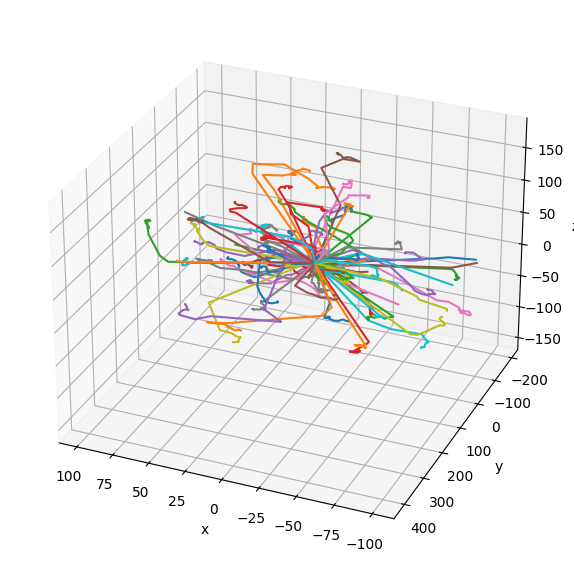

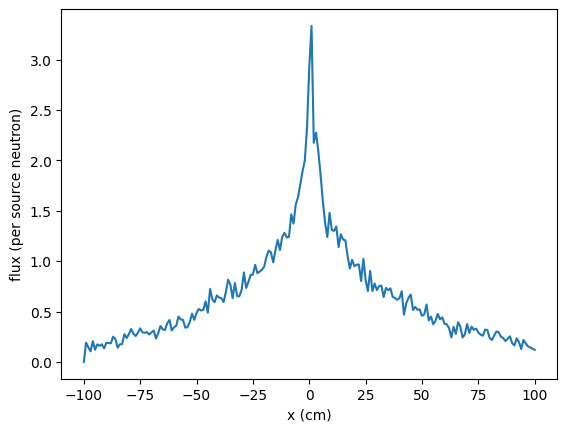

In [56]:
from mpl_toolkits.mplot3d import Axes3D

N=5000
D=100 #cm half width of the 1-dimensional slab
E0=3e7 #eV
A=1
alpha=(A-1)**2/(A+1)**2

#x coordinates and flux initialization
#we will score in 201 bins along the x-axis
x=np.linspace(-D,D,201)
flux=np.zeros(len(x))


#We create the canvas for a 3D plot of the trajectories
fig = plt.figure(figsize=plt.figaspect(1.0)*1.5) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.subplots(subplot_kw={"projection": "3d"})
for i in range(N): #for every neutron
    #we initializes lists to store the coordinates of the neutron along its trajectory
    Xs=[]
    Ys=[]
    Zs=[]

    #we initialize the neutron energy
    E=E0
    
    #we sample a random source location on a plane x=0.0, y and z is between -500 and 500. This is an arbitrary choice
    #we just picked a large number, considering that the slab is infinite in y and z direction.
    #this would be a planar source: coord=np.array([0.0,np.random.uniform(-500.0,500.0),np.random.uniform(-500.0,500.0)]) #plate
    coord=np.array([0.0,0.0,0.0]) #point source
    
    #we sample a random initial direction the neutron travels to
    direction=randomDir()
    
    #now we track the neutron until it dies. We could pick a slighly higher energy condition than 0.0.
    #in case more nuclides are present one needs an other step to sample nuclide
    while E>0.0:
        #GET the macroscopic cross sections at energy E
        SigS=np.interp(E,Es,MXSs) 
        SigC=np.interp(E,Ec,MXSc)
        SigT=SigS+SigC
        #GET distance to collision
        dist=distanceToCollision(SigT)
        #STORE the locations for the trajectory
        Xs.append(coord[0])
        Ys.append(coord[1])
        Zs.append(coord[2])
        #COORDINATE OF NEXT COLLISION
        coord=coord + dist*direction
        #TYPE OF NEXT COLLISION
        rtype=reactionType(SigS,SigC,SigT)
        if np.abs(coord[0])>D:  #if the x coordinate is larger than the half width: leakage
            break
        elif rtype=='capture':
            #if neutron captured we break out from the while loop
            #and score to the flux estimator
            flux[np.digitize(coord[0],x)]=flux[np.digitize(coord[0],x)]+1/SigT/N
            break
        else:
            #if neutron scattered we score to the flux estimate
            #and calculate the direction after the scattering event
            flux[np.digitize(coord[0],x)]=flux[np.digitize(coord[0],x)]+1/SigT/N
            E,muL=elasticScatter(E)
            direction=transformDir(direction[0],direction[1],direction[2],muL)

    #we plot the trajectory of the given neutron. We could store the trajectory as well for later use 
    #but we only do this for the first 100 neutrons, otherwise the figure would be to busy
    if i<100:
        ax.plot3D(Xs,Ys,Zs,label=str(i))

#once all the neutrons are tracked we plot the trajectories and we plot the flux
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#plt.legend()
ax.azim = 113
ax.elev = 28
plt.show()

plt.figure()
plt.plot(x,flux)
plt.xlabel('x (cm)')
plt.ylabel('flux (per source neutron)')
plt.show()

## Experiments

Study what happens if you 

- increase the number of particles in the simulation (increase it by one order of magnitude, for more the calculation will take ages).
- change the density of the medium
- change the initial energy of the neutrons

Conclude your findings!


# Conclusion

The first thing to notice is that an increase in particles results in a smoother flux profile and reduced noise.
Next, we can see that the flux is higher in the center of the slab and decreases towards the edges in all examples. 

When we decreased the energy of the source neutrons, the flux profile became smoother and the flux distribution became steeper. When the energy was increased, the flux became less smooth, with a higher maximum value of flux. It can also be seen that some neutrons escaped.

When the density was decreased, a similar pattern was observed. The flux profile is much steeper, and the neutrons can't travel as far. Here, a drop in the maximum flux can also be seen, which was not found in the decrease in energy.


<table>
  <tr>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/ca249688-de7c-4e81-8c3c-db9ded065762" alt="N=500, D = 100, E=3e6" width="500"/></td>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/012fc3cc-a9d2-4bed-acba-f84ac1363e7c" alt="N=5000, D = 100, E=3e6" width="500"/></td>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/3bd5868f-7a59-4621-a6e3-7ef8d9b78690" alt="N=500, D = 100, E=1e6" width="500"/></td>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/053805f0-88af-4064-b5ea-f7f6fa49a421" alt="N=500, D = 50, E=3e6" width="500"/></td>
  </tr>
  <tr>
    <td align="center">N=500, D = 1, E=3e6</td>
    <td align="center">N=5000, D = 1, E=3e6</td>
    <td align="center">N=5000, D = 1, E=3e5</td>
    <td align="center">N=5000, D = 2, E=3e6</td>
  </tr>
</table>

<table>
  <tr>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/8ba3afe6-5ccf-4c0f-bbc4-5dd61b8fc25b" alt="N=500, D = 100, E=3e6" width="500"/></td>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/3a9245b2-b932-45ac-b035-5009cd0c7b30" alt="N=5000, D = 100, E=3e6" width="500"/></td>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/188feb96-adfc-4c43-9495-bcfc1227148c" alt="N=5000, D = 100, E=1e6" width="500"/></td>
    <td><img src="blob:vscode-webview://0nq95itdalc8l33fjio0i48iuif3ib8se13rvvilo33aklasjpjr/ca4e977a-527b-4e86-97d1-aa30d2d9b02f" alt="N=5000, D = 50, E=3e6" width="500"/></td>
  </tr>
  <tr>
    <td align="center">N=500, D = 1, E=3e6</td>
    <td align="center">N=5000, D = 1, E=3e6</td>
    <td align="center">N=5000, D = 1, E=3e5</td>
    <td align="center">N=5000, D = 2, E=3e6</td>
  </tr>
</table>

